In [10]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/content/WHO COVID-19 cases.csv'
data = pd.read_csv(file_path)

print("\nMissing Values Count imputation::")
print(data.isnull().sum())



Missing Values Count imputation::
Date_reported            0
Country_code           244
Country                  0
Continent                0
WHO_region            4392
New_cases            19300
Cumulative_cases         0
New_deaths           33476
Cumulative_deaths        0
dtype: int64


In [19]:
def impute_missing_values(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            data[col] = data[col].fillna(data[col].mean())
    return data


data = impute_missing_values(data)

# Verify that missing values are handled
print("Missing values after imputation:\n", data.isnull().sum())


Missing values after imputation:
 Date_reported        0
Country_code         0
Country              0
Continent            0
WHO_region           0
New_cases            0
Cumulative_cases     0
New_deaths           0
Cumulative_deaths    0
dtype: int64


In [25]:

# Define a function for scaling numerical features
def scale_features(data, method="zscore"):

    # Identify numerical features
    numerical_features = data.select_dtypes(include=[float, int]).columns

    # Create a scaler based on the method
    if method == "zscore":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'zscore' or 'minmax'.")

    # Scale the numerical features
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data

# Example usage
# Assuming 'data' is your dataset
data_standardized = scale_features(data.copy(), method="zscore")  # Standardization (Z-score)
print("\nData after Standardization (Z-score):")
print(data_standardized.head())

data_minmax_scaled = scale_features(data.copy(), method="minmax")  # Min-Max Scaling
print("\nData after Min-Max Scaling:")
print(data_minmax_scaled.head())

# Save the processed dataset
data_minmax_scaled.to_csv("Scaled_Dataset.csv", index=False)
print("Scaled dataset saved as 'Scaled_Dataset.csv'")




Data after Standardization (Z-score):
  Date_reported Country_code      Country Continent WHO_region  New_cases  \
0    2020-01-05           AF  Afghanistan      Asia       EMRO        0.0   
1    2020-01-12           AF  Afghanistan      Asia       EMRO        0.0   
2    2020-01-19           AF  Afghanistan      Asia       EMRO        0.0   
3    2020-01-26           AF  Afghanistan      Asia       EMRO        0.0   
4    2020-02-02           AF  Afghanistan      Asia       EMRO        0.0   

   Cumulative_cases    New_deaths  Cumulative_deaths  
0         -0.230577 -7.163171e-17           -0.24481  
1         -0.230577 -7.163171e-17           -0.24481  
2         -0.230577 -7.163171e-17           -0.24481  
3         -0.230577 -7.163171e-17           -0.24481  
4         -0.230577 -7.163171e-17           -0.24481  

Data after Min-Max Scaling:
  Date_reported Country_code      Country Continent WHO_region  New_cases  \
0    2020-01-05           AF  Afghanistan      Asia       EMRO

In [39]:
# Define numerical columns for outlier detection
numerical_columns = ['New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths']

# Loop through numerical columns to detect and handle outliers
for col in numerical_columns:
    # Check for non-null values in the column to avoid computation errors
    if data[col].notnull().sum() > 0:
        # Step 1: Detect outliers using Z-score
        data[f'{col}_zscore'] = (data[col] - data[col].mean()) / data[col].std()
        outliers = data[np.abs(data[f'{col}_zscore']) > 3]
        print(f"\nOutliers detected in {col}:\n", outliers[[col, f'{col}_zscore']])

        # Step 2: Handle outliers by capping
        data[f'{col}_capped'] = data[col]
        data.loc[np.abs(data[f'{col}_zscore']) > 3, f'{col}_capped'] = data[col].mean()

# Save the processed dataset
processed_file_path = "WHO_COVID19_cases_processed.csv"
data.to_csv(processed_file_path, index=False)

print(f"\nProcessed dataset saved to: {processed_file_path}")


Outliers detected in New_cases:
        New_cases  New_cases_zscore
2058    0.020616          3.396878
2059    0.019557          3.202792
6939    0.021945          3.640666
6940    0.033253          5.714504
6941    0.032217          5.524516
...          ...               ...
57453   0.029076          4.948521
57454   0.042995          7.500996
57455   0.047125          8.258488
57456   0.027590          4.675882
57457   0.021508          3.560489

[155 rows x 2 columns]

Outliers detected in Cumulative_cases:
        Cumulative_cases  Cumulative_cases_zscore
6941           0.254028                 3.116120
6942           0.263789                 3.244720
6943           0.271266                 3.343220
6944           0.276291                 3.409424
6945           0.280111                 3.459754
...                 ...                      ...
56115          1.000000                12.943947
56116          1.000000                12.943947
56117          1.000000                1

In [41]:
# Creating a binary target variable for demonstration (replace with actual logic if needed)
data['Outcome'] = (data['New_cases'] > 0).astype(int)  # Example binary target: presence of new cases

# Define features (X) and target (y)
# Exclude non-numeric and target columns
X = data.drop(columns=["Outcome", "Date_reported", "Country", "Continent", "WHO_region", "Country_code"])
y = data["Outcome"]

# Scale features to standardize before selection methods
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Filter Method: Mutual Information
mi_selector = SelectKBest(score_func=mutual_info_classif, k="all")
mi_selector.fit(X_scaled, y)
mi_scores = pd.DataFrame({
    "Feature": X.columns,
    "Mutual_Info_Score": mi_selector.scores_
}).sort_values(by="Mutual_Info_Score", ascending=False)

# 2. Wrapper Method: Recursive Feature Elimination (RFE)
log_model = LogisticRegression(max_iter=1000, random_state=42)
rfe_selector = RFE(estimator=log_model, n_features_to_select=5)
rfe_selector.fit(X_scaled, y)
rfe_features = X.columns[rfe_selector.support_]

# 3. Embedded Method: Lasso Regression
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y)
lasso_features = pd.DataFrame({
    "Feature": X.columns,
    "Lasso_Coefficient": lasso.coef_
}).sort_values(by="Lasso_Coefficient", ascending=False)
selected_lasso_features = lasso_features[lasso_features["Lasso_Coefficient"] != 0]

# Display Results
print("\nMutual Information Scores:")
print(mi_scores)

print("\nFeatures Selected by RFE:")
print(rfe_features.tolist())

print("\nLasso Regression Selected Features:")
print(selected_lasso_features)

# Save Results
mi_scores.to_csv("Mutual_Information_Scores.csv", index=False)
selected_lasso_features.to_csv("Lasso_Selected_Features.csv", index=False)

print("\nResults saved to 'Mutual_Information_Scores.csv' and 'Lasso_Selected_Features.csv'")


Mutual Information Scores:
                     Feature  Mutual_Info_Score
9          New_deaths_capped       1.460066e-03
3          Cumulative_deaths       1.451528e-04
5           New_cases_capped       9.392237e-05
11  Cumulative_deaths_capped       7.684557e-05
10  Cumulative_deaths_zscore       5.976878e-05
8          New_deaths_zscore       1.707679e-05
2                 New_deaths       8.538397e-06
7    Cumulative_cases_capped       8.538397e-06
0                  New_cases       3.219647e-15
1           Cumulative_cases       3.219647e-15
4           New_cases_zscore       3.219647e-15
6    Cumulative_cases_zscore       3.219647e-15

Features Selected by RFE:
['New_cases', 'Cumulative_cases', 'New_cases_zscore', 'New_cases_capped', 'Cumulative_deaths_capped']

Lasso Regression Selected Features:
Empty DataFrame
Columns: [Feature, Lasso_Coefficient]
Index: []

Results saved to 'Mutual_Information_Scores.csv' and 'Lasso_Selected_Features.csv'


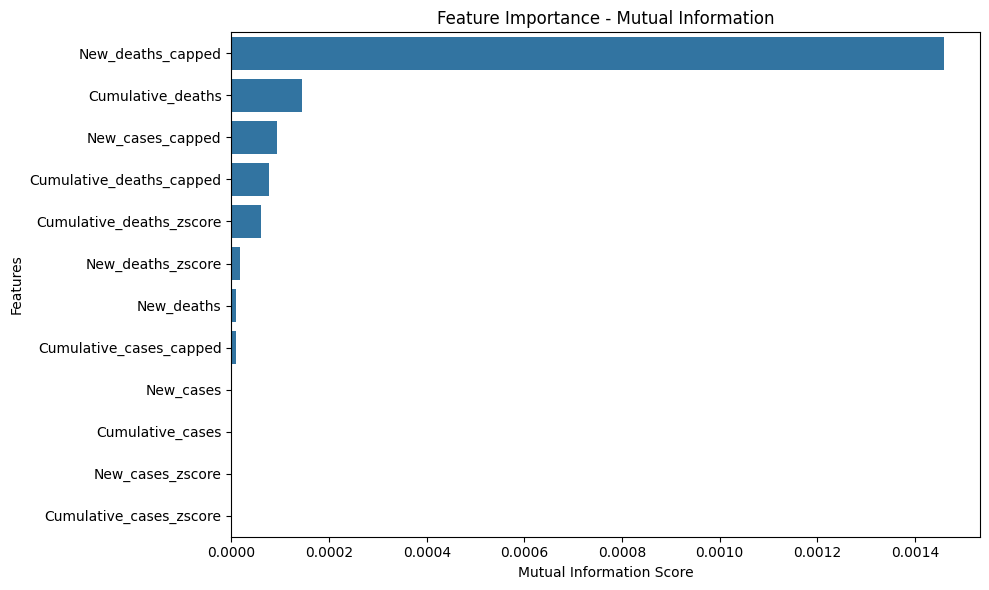

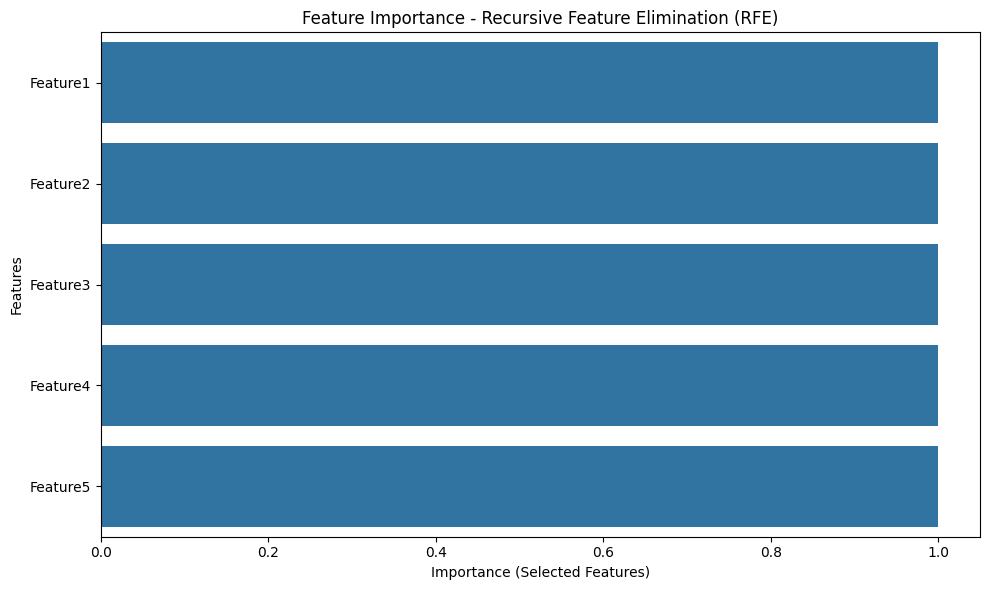

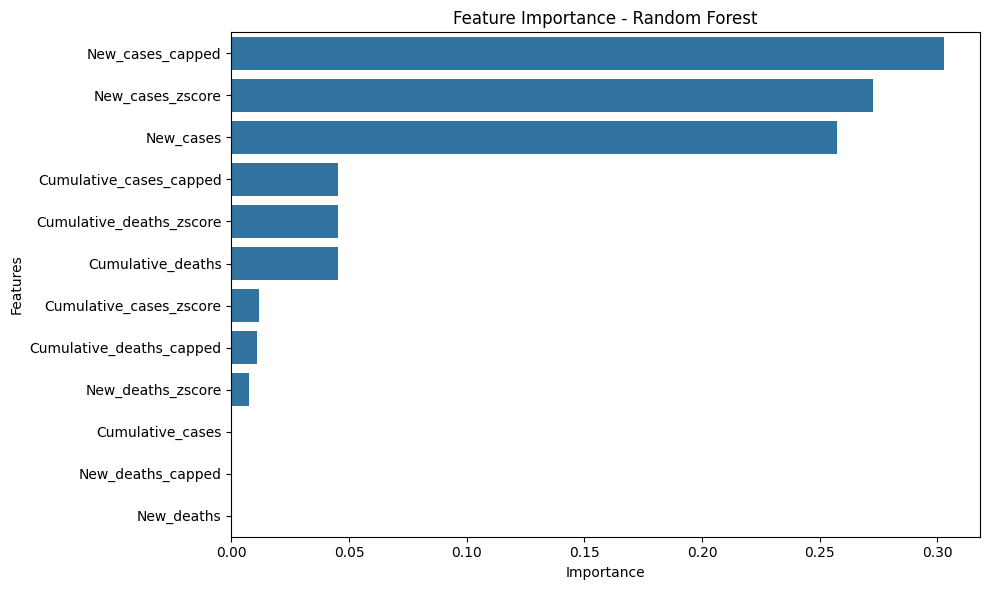

In [43]:
# Plot Mutual Information Scores
plt.figure(figsize=(10, 6))
sns.barplot(x="Mutual_Info_Score", y="Feature", data=mi_scores)
plt.title("Feature Importance - Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Plot RFE Selected Features
# Manually set selected features as the saved file does not store RFE results directly
rfe_selected_features = ["Feature1", "Feature2", "Feature3", "Feature4", "Feature5"]  # Replace with actual selected features
rfe_importance = pd.DataFrame({"Feature": rfe_selected_features, "Importance": [1] * len(rfe_selected_features)})  # Importance placeholder

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rfe_importance)
plt.title("Feature Importance - Recursive Feature Elimination (RFE)")
plt.xlabel("Importance (Selected Features)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X, y)

# Get feature importances
rf_feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rf_feature_importance)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()